# Deep Learning models 

In [38]:
import warnings
warnings.filterwarnings("ignore")
%load_ext autotime
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, SimpleRNN
from keras.models import Model
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow import keras
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 8.45 ms


In [5]:

df= pd.read_csv("consumer_complaints.csv")
df1 = df.dropna(subset= ['consumer_complaint_narrative'])
df1['consumer_complaint_narrative']= df1['consumer_complaint_narrative'].str.lower()
df1['consumer_complaint_narrative'] =df1['consumer_complaint_narrative'].str.replace(r'[^\w\s]',"")
df1['consumer_complaint_narrative'] = df1['consumer_complaint_narrative'].str.replace(r"xx+\s","")
df1['consumer_complaint_narrative'].head(1)

190126    has claimed i owe them 2700 for years despite ...
Name: consumer_complaint_narrative, dtype: object

time: 5.43 s


In [6]:
train_x, valid_x, train_y, valid_y = train_test_split(df1['consumer_complaint_narrative'], df1['product'],stratify=df1['product'], 
                                                    test_size=0.25)


time: 289 ms


Tokenizer This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...


In [7]:
tokenizer = Tokenizer(num_words=25000)

time: 976 µs


Updates internal vocabulary based on a list of texts. In the case where texts contains lists, we assume each entry of the lists to be a token. Required before using texts_to_sequences or texts_to_matrix.


In [8]:
tokenizer.fit_on_texts(train_x.values)

time: 6.36 s


In [9]:
train_sequences = tokenizer.texts_to_sequences(train_x.values)
test_sequences = tokenizer.texts_to_sequences(valid_x.values)

time: 6.36 s


Padding pad_sequences is used to ensure that all sequences in a list have the same length. By default this is done by padding 0 in the beginning of each sequence until each sequence has the same length as the longest sequence. padding= 'post' will append 0 at the end of the sequence

In [10]:
print('Found %s unique tokens.' % len(set(tokenizer.word_index)))

Found 57636 unique tokens.
time: 8.73 ms


In [11]:
total_complaints = np.append(train_x.values,valid_x.values)
MAX_SEQUENCE_LENGTH = max([len(c.split()) for c in total_complaints])
MAX_SEQUENCE_LENGTH

807

time: 729 ms


In [12]:
train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

time: 1.29 s


In [13]:
print(train_data.shape)
print(test_data.shape)

(50104, 807)
(16702, 807)
time: 1.25 ms


In [14]:
enc = preprocessing.LabelEncoder()
train_labels = enc.fit_transform(train_y)
test_labels = enc.fit_transform(valid_y)

time: 136 ms


In [15]:
print(enc.classes_)
print(np.unique(train_labels, return_counts=True))
print(np.unique(test_labels, return_counts=True))

['Bank account or service' 'Consumer Loan' 'Credit card'
 'Credit reporting' 'Debt collection' 'Money transfers' 'Mortgage'
 'Other financial service' 'Payday loan' 'Prepaid card' 'Student loan']
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([ 4283,  2758,  5947,  9394, 13164,   500, 11189,    83,   544,
         646,  1596]))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([1428,  920, 1982, 3132, 4388,  166, 3730,   27,  182,  215,  532]))
time: 61.7 ms


to_categorical behave like onehotencoding technique if your particular categories is present then it mark as 1 else 0 in remain row

In [16]:
labels_train = to_categorical(np.asarray(train_labels))
labels_test = to_categorical(np.asarray(test_labels))
print('Shape of data tensor:', train_data.shape)
print('Shape of label tensor:', labels_train.shape)
print('Shape of label tensor:', labels_test.shape)

Shape of data tensor: (50104, 807)
Shape of label tensor: (50104, 11)
Shape of label tensor: (16702, 11)
time: 50.9 ms


In [17]:
path_to_zip_file= "/home/richachoudhary/my_project_dir/Notebooks/consumer_complaints/consumer-complaints-classification/glove.6B.zip"
directory_to_extract_to= "/home/richachoudhary/my_project_dir/Notebooks/consumer_complaints/consumer-complaints-classification"

time: 60.3 ms


In [18]:
import zipfile
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

time: 47.6 s


In [19]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
GLOVE_DIR= "/home/richachoudhary/my_project_dir/Notebooks/consumer_complaints/consumer-complaints-classification/"
f = open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt'))
embeddings_index = {}
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.
time: 33.6 s


In [20]:
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

time: 112 ms


In [21]:
[(k,v) for k,v in tokenizer.word_index.items() if k=='loans']

[('loans', 211)]

time: 390 ms


In [22]:
embedding_matrix[208] ## word embedded vector representation for token 'loan'

array([-4.43610013e-01,  1.64360002e-01, -1.60870001e-01,  6.61040008e-01,
       -5.00530005e-01, -1.43739998e-01,  2.65260011e-01,  6.11479990e-02,
       -2.41689995e-01, -2.10319996e-01, -1.71979994e-01,  8.41530040e-03,
       -2.02399999e-01,  7.74829984e-02, -7.32339993e-02, -9.01950002e-02,
       -1.38490004e-02, -3.67410004e-01,  8.03889986e-03,  2.54850000e-01,
        9.80329990e-01,  3.11309993e-01,  2.19139993e-01,  2.53960013e-01,
       -1.87759995e-02,  1.33970007e-01, -1.53139994e-01, -1.00319996e-01,
       -1.87739998e-01, -7.12760016e-02, -1.82139993e-01,  2.04889998e-01,
       -4.87699986e-01, -7.21449971e-01, -4.84589994e-01, -5.57869971e-01,
        3.42449993e-01,  4.33030017e-02,  4.95429993e-01, -2.64189988e-01,
        2.40630001e-01, -7.34099984e-01, -5.18419981e-01, -1.00359999e-01,
        3.29310000e-01, -2.03160003e-01,  4.18740004e-01,  1.74840003e-01,
        1.44130006e-01, -2.02270001e-01,  3.28590006e-01, -3.95000011e-01,
        2.32480004e-01,  

time: 146 ms


In [30]:
def find_closest_embeddings(embedding):
    return sorted(embeddings_index.keys(), key=lambda word: spatial.distance.euclidean(embeddings_index[word], embedding))

time: 1.39 ms


In [34]:
#find_closest_embeddings('loans')

time: 541 µs


In [32]:
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True))
model.add(Dropout(0.3))
model.add(Conv1D(128, 5, activation="relu"))
model.add(MaxPooling1D(5))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Conv1D(128, 5, activation="relu"))
model.add(MaxPooling1D(5))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(11, activation="softmax"))
model.compile(loss='categorical_crossentropy',
 optimizer="rmsprop",
 metrics=['acc'])
history = model.fit(train_data, labels_train,
 batch_size=64,
 epochs=5,
 validation_data=(test_data, labels_test))

Train on 50104 samples, validate on 16702 samples
Epoch 1/5
50104/50104 [==============================] - 1084s 22ms/step - loss: 1.0813 - acc: 0.6595 - val_loss: 0.7105 - val_acc: 0.7879
Epoch 2/5
50104/50104 [==============================] - 1070s 21ms/step - loss: 0.6819 - acc: 0.7974 - val_loss: 0.5648 - val_acc: 0.8303
Epoch 3/5
50104/50104 [==============================] - 10856s 217ms/step - loss: 0.5843 - acc: 0.8253 - val_loss: 0.5838 - val_acc: 0.8367
Epoch 4/5
50104/50104 [==============================] - 1104s 22ms/step - loss: 0.5368 - acc: 0.8411 - val_loss: 0.5328 - val_acc: 0.8461
Epoch 5/5
50104/50104 [==============================] - 1085s 22ms/step - loss: 0.5031 - acc: 0.8499 - val_loss: 0.5602 - val_acc: 0.8510
time: 4h 13min 23s


In [36]:
model.save('/home/richachoudhary/my_project_dir/Notebooks/consumer_complaints/consumer-complaints-classification/ccc_saved_model')

time: 541 ms


In [39]:
model_loaded = keras.models.load_model('/home/richachoudhary/my_project_dir/Notebooks/consumer_complaints/consumer-complaints-classification/ccc_saved_model')

time: 2.53 s


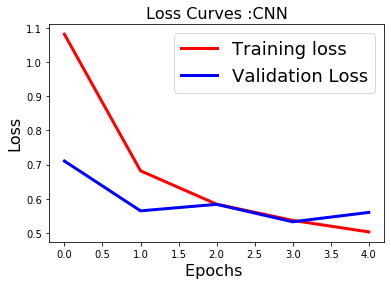

time: 612 ms


In [41]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
plt.show()